In [36]:
import os
import netCDF4 as nc4
import pandas as pd
from tqdm import tqdm
import numpy as np
import rasterio
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
import pyttsx3

plt.rc('font',family='Times New Roman') #设置全局字体

## 计算年均值

In [55]:
year = 2018
# 文件夹根路径
files_path = "D:\\PhD\\data\\ISCCP-ITP\\" + str(year)


# 初始化总和和计数
total_sum = None
count = 0

# 遍历文件夹中的所有文件
for filename in tqdm(os.listdir(files_path)):
    # 检查文件是否为nc文件
    if filename.endswith(".nc"):
        file_path = os.path.join(files_path, filename)
        try:
            # 打开nc文件
            with nc4.Dataset(file_path, 'r') as hdf_file:
                # 获取指定数据集
                dataset = hdf_file['daily_global_radiation']
                # 读取数据
                data = np.array(dataset)

                # 初始化总和
                if total_sum is None:
                    total_sum = data.astype(np.float64)
                else:
                    # 累加数据
                    total_sum += data

                # 增加计数
                count += 1
        except Exception as e:
            print(f"处理文件 {file_path} 时出错: {e}")

# 计算平均值
if count > 0:
    mean_data = total_sum / count
else:
    print("没有成功处理的文件，无法计算平均值。")
    mean_data = None

# 保存mean_data
# np.save("D:\\PhD\\data\\ISCCP-ITP\\npy\\" + str(year) + "-output.npy", mean_data)

print(f"{year}--------全年平均值为：------{np.nanmean(mean_data)}")
del mean_data

engine = pyttsx3.init()  # 创建engine并初始化
engine.say("复制平均值")
engine.runAndWait()

100%|██████████| 365/365 [00:24<00:00, 15.02it/s]


2018--------全年平均值为：------156.79511363690182


### 通过npy文件，计算2000~2018年的均值，并导出为tif

In [74]:
# npy根目录
files_path = "D:\\PhD\\data\\ISCCP-ITP\\npy"
# 保存为tif文件
tif_file_path = "D:\\PhD\\UCAS\\Undergraduate\\Projects\\Python\\2000_2018_year_avg\\2000_2018_ISCCP.tif"

# 初始化总和和计数
total_sum = None
count = 0

# 遍历文件夹中的所有文件
for filename in tqdm(os.listdir(files_path)):
    # 检查文件是否为npy文件
    if filename.endswith(".npy"):
        file_path = os.path.join(files_path, filename)
        # 打开npy文件
        data = np.load(file_path)

        # 初始化总和
        if total_sum is None:
            total_sum = data.astype(np.float32)
        else:
            # 累加数据
            total_sum += data
        # 增加计数
        count += 1
# 计算平均值
if count > 0:
    mean_data_years = total_sum / count
else:
    print("没有成功处理的文件，无法计算平均值。")
    mean_data_years = None

data = mean_data_years
del mean_data_years
# (x方向上的像素分辨率，表示x方向上的y方向倾斜：表示x方向上的y方向倾斜，起始经度，表示y方向上的x方向倾斜，y方向上的像素分辨率常为负值，起始纬度：左上角)
transform = rasterio.transform.Affine(0.1, 0, 0.05, 0, -0.1, 89.95)
crs = rasterio.crs.CRS.from_epsg(4326)

# 打开一个新的 TIFF 文件进行写入
with rasterio.open(
    tif_file_path,
    'w',
    driver='GTiff',
    height=data.shape[0],
    width=data.shape[1],
    count=1,
    dtype=data.dtype,
    crs=crs,
    transform=transform,
) as tif_file:
    # 将数据写入 TIFF 文件
    tif_file.write(data, 1)

print(f"成功转换为 {tif_file_path}")

100%|██████████| 19/19 [00:00<00:00, 44.59it/s]

成功转换为 D:\PhD\UCAS\Undergraduate\Projects\Python\2000_2018_year_avg\2000_2018_ISCCP.tif


In [70]:
mean_data_years.mean()

156.56901591091665

In [ ]:
all = []
a = np.array([[-1.0, 2, 3], [4, 5, 6], [7, 8, -1]])
b = np.array([[1.0, 2, 3], [4, 5, 6], [7, 8, 9]])
c = np.array([[1, 2, 3], [4, 5, 6], [7, 8, 9]])
d = np.array([[1, 2, 3], [4, 5, 6], [7, 8, 9]])

a[a == -1] = np.nan

all.append(a)
all.append(b)
all.append(c)
all.append(d)
all = np.array(all)

mean_data2 = np.mean(all, axis=0)
np.nanmean(mean_data2)

## 可视化

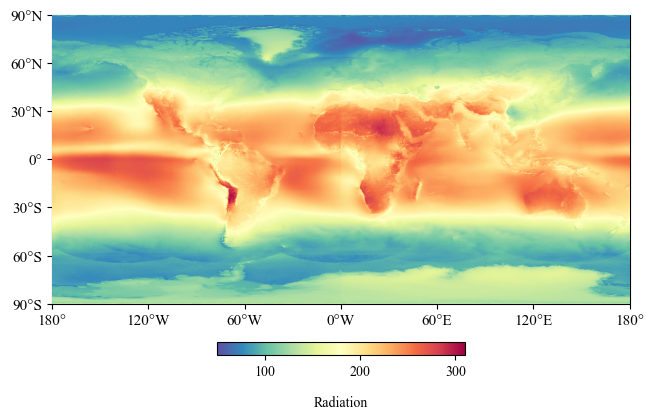

In [75]:
# 读取GeoTiff文件
src = rasterio.open(tif_file_path)
data = src.read(1) # 读取第一个波段
# nodata_value = np.nan  # 获取nodata值
nodata_value = -1  # 获取nodata值
data = np.ma.masked_where(data == nodata_value, data) # 将nodata值替换为NaN并创建掩码
extent = [src.bounds.left, src.bounds.right, src.bounds.bottom, src.bounds.top] # 获取图像边界

# 创建画布
fig, ax = plt.subplots(figsize=(8, 5), subplot_kw={'projection': ccrs.PlateCarree()})

# 可视化
# im = ax.imshow(data, origin='upper', extent=extent, transform=ccrs.PlateCarree(), cmap='Spectral_r', vmin=0, vmax=400, zorder=10)
im = ax.imshow(data, origin='upper', extent=extent, transform=ccrs.PlateCarree(), cmap='Spectral_r',  zorder=10)
# im.axes.get_xaxis().set_visible(False) # 隐藏坐标轴标签
# im.axes.get_yaxis().set_visible(False)
# 添加colorbar
cbar = plt.colorbar(im, ax=ax, orientation='horizontal', shrink=0.4, pad=0.1)
cbar.set_label("Radiation", labelpad=12)
cbar.ax.xaxis.set_label_position('bottom')
# 关闭 GeoTIFF
src.close()

# 设置 axis ticks
ax.set_xticks([-180, -120, -60, 0, 60, 120, 180], crs=ccrs.PlateCarree())
ax.set_yticks([-90, -60, -30, 0, 30, 60, 90], crs=ccrs.PlateCarree())
ax.tick_params(axis='both', labelsize=11)
ax.grid(linewidth=0.2, color='#949494', linestyle='--', zorder=0)

# 设置 tick labels
lon_formatter = LongitudeFormatter()
lat_formatter = LatitudeFormatter()
ax.xaxis.set_major_formatter(lon_formatter)
ax.yaxis.set_major_formatter(lat_formatter)
plt.show()